In [22]:
## Import packages needed for this script
import numpy as np
import pandas as pd 
import mne
import matplotlib.pyplot as plt

In [2]:
## Importing data and preprocessing data

path='/Users/aazeez/Documents/Personal/erdosbootcamp/Project'
data = pd.read_csv(path+'/train_set.csv')
data = data.drop(columns = ['Unnamed: 0', 'err', 'file_loc', 'trial_no']) #, 'trial_no', 'patient_no'
data['alcoholic'] = data['alcoholic'].map({True:1, False:0})
data['match'] = data['match'].map({'obj':0, 'nomatch':1, 'match':2})

## Separate data between alcoholic and control
alcoholic = data[data['alcoholic']==True]
control = data[data['alcoholic']==False ]

alcoholic = alcoholic.drop(columns=['alcoholic'])
control = control.drop(columns=['alcoholic'])

In [3]:
## Setting channels and frequency for MNE 
ch_names = ['AF1', 'AF2', 'AF7', 'AF8', 'AFZ', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPZ', 'CZ', 'F1',
       'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4',
       'FC5', 'FC6', 'FCZ', 'FP1', 'FP2', 'FPZ', 'FT7', 'FT8', 'FZ', 'O1',
       'O2', 'OZ', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO1',
       'PO2', 'PO7', 'PO8', 'POZ', 'PZ', 'T7', 'T8', 'TP7', 'TP8', 'X', 'Y',
       'nd']

sfreq = 256 #Hz

In [7]:
def read_data(data):
    ## Setting data
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    raw = mne.io.RawArray(data.transpose().iloc[1:-1], info) #Transpose data
    
    ## Adding Stimulus to data
    info = mne.create_info(['STI'], raw.info['sfreq'], ['stim']) 
    stim_raw = mne.io.RawArray(data.transpose().iloc[-1:], info) #Transpose data
    raw.add_channels([stim_raw], force_update_info=True) #

    ## Filtering data
    raw.filter(l_freq=0.01, h_freq=40, picks=ch_names)
    
    ## Epochs
    epochs = mne.make_fixed_length_epochs(raw, duration=1)

    array = epochs.get_data()
    
    return array

In [8]:
#%%capture
a = read_data(control.iloc[:,:-1])

Creating RawArray with float64 data, n_channels=64, n_times=76800
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=76800
    Range : 0 ... 76799 =      0.000 ...   299.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 84481 samples (330.004 sec)



<ipython-input-7-a68e60d3f112>:12: RuntimeWarning: filter_length (84481) is longer than the signal (76800), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=0.01, h_freq=40, picks=ch_names)


Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 300 events and 256 original time points ...
0 bad epochs dropped


In [9]:
a.info

AttributeError: 'numpy.ndarray' object has no attribute 'info'

In [10]:
a.shape #no of events, no of channels (including stimulus), no_times
# no of events = 30 trials  x 10 patients in the control group 

(300, 65, 256)

In [11]:
control_patients = [patient for patient in control.patient_no.unique()]
alcoholic_patients = [patient for patient in alcoholic.patient_no.unique()]

In [12]:
%%capture
control_epochs_array = []
for patient in control_patients:
    control_epochs_array.append(read_data(control[control.patient_no==patient].iloc[:,:-1]))
    
alcoholic_epochs_array = []
for patient in alcoholic_patients:
    alcoholic_epochs_array.append(read_data(alcoholic[alcoholic.patient_no==patient].iloc[:,:-1]))

In [13]:
alcoholic_epochs_array[0].shape
#no of events (trails), no of channels (including stimulus), no_times

(30, 65, 256)

In [14]:
## Assign labels (y)
control_epoch_labels = [len(i)*[0] for i in control_epochs_array]
alcoholic_epoch_labels = [len(i)*[1] for i in alcoholic_epochs_array]

len(control_epoch_labels), len(alcoholic_epoch_labels)

(10, 10)

In [15]:
data_list = control_epochs_array + alcoholic_epochs_array
label_list = control_epoch_labels + alcoholic_epoch_labels

In [16]:
group_list = [[i]*len(j) for i,j in enumerate(data_list)]
len(group_list) #Total patients (control+alcoholic)

20

In [17]:
data_array = np.vstack(data_list) #Processed signal 
label_array = np.hstack(label_list) #label Al, C 
group_array = np.hstack(group_list) 

print(data_array.shape, label_array.shape, group_array.shape)

(600, 65, 256) (600,) (600,)


In [20]:
## Save arrays
np.save(path+'/data_array.npy', data_array) 
np.save(path+'/label_array.npy', label_array)
np.save(path+'/group_array.npy', group_array)

In [21]:
data_array.shape

(600, 65, 256)

In [117]:
print(control.shape)


(76800, 67)


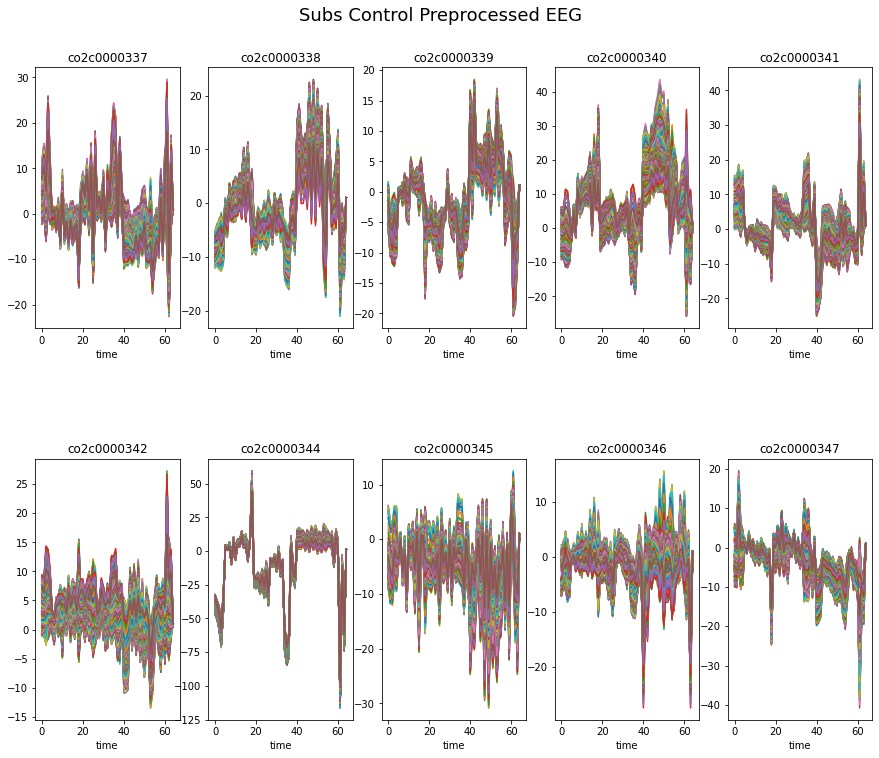

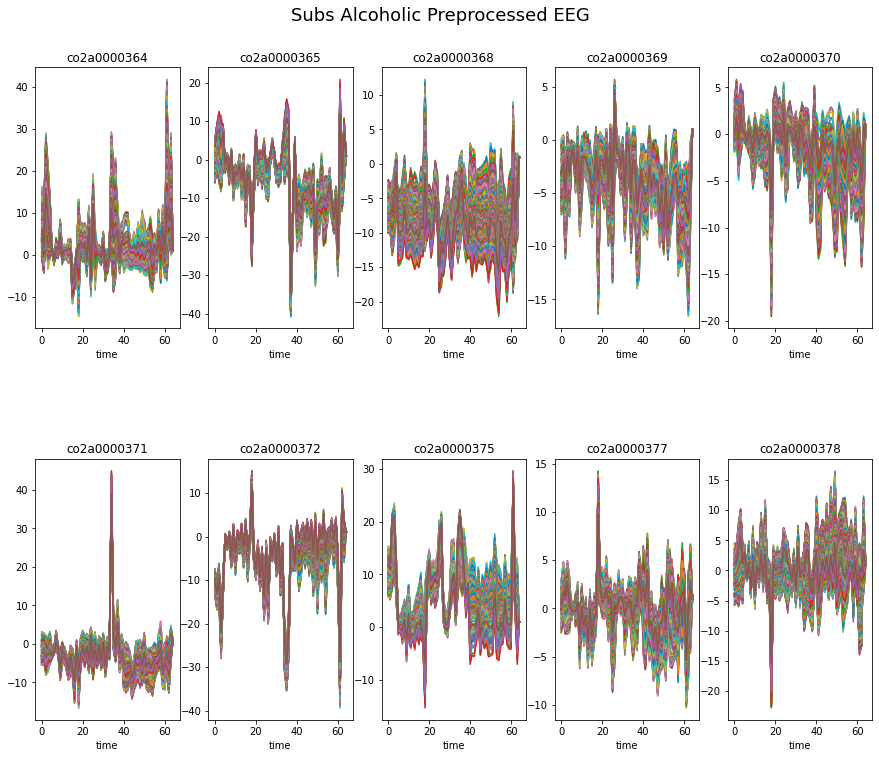

In [201]:
#Ploting Raw EEG data 
nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15, 12))                 
fig.suptitle("Subs Control Preprocessed EEG", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

crt=np.vstack(control_epochs_array)
alc=np.vstack(alcoholic_epochs_array)

subindx=np.linspace(0, 300, num=11)
# print(subindx)

for sub, ax in zip(range(len(subindx)-1),axs.ravel()):
# for sub, ax in zip(sublist, axs.ravel()):

    start=int(subindx[sub])
    stop =int(subindx[sub]+30)
#     print(start)
#     print(stop)
#     print()
    crt_sub=crt[start:stop:1,:,:].mean(axis=0)
#     print(crt_sub.shape)
#     crt_sub.plot(ax=ax)
    ax.plot(crt_sub)
    ax.set_title(control_patients[sub])
    ax.set_xlabel("time")
plt.savefig('Subs Control Preprocessed EEG.png')
plt.show()



nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15, 12))                 
fig.suptitle("Subs Alcoholic Preprocessed EEG", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

alc=np.vstack(alcoholic_epochs_array)

subindx=np.linspace(0, 300, num=11)
# print(subindx)

for sub, ax in zip(range(len(subindx)-1),axs.ravel()):
# for sub, ax in zip(sublist, axs.ravel()):

    start=int(subindx[sub])
    stop =int(subindx[sub]+30)
#     print(start)
#     print(stop)
#     print()
    alc_sub=alc[start:stop:1,:,:].mean(axis=0)
#     print(crt_sub.shape)
#     crt_sub.plot(ax=ax)
    ax.plot(alc_sub)
    ax.set_title(alcoholic_patients[sub])
    ax.set_xlabel("time")
    
plt.savefig('Subs Alcoholic Preprocessed EEG.png')
plt.show()
    
    

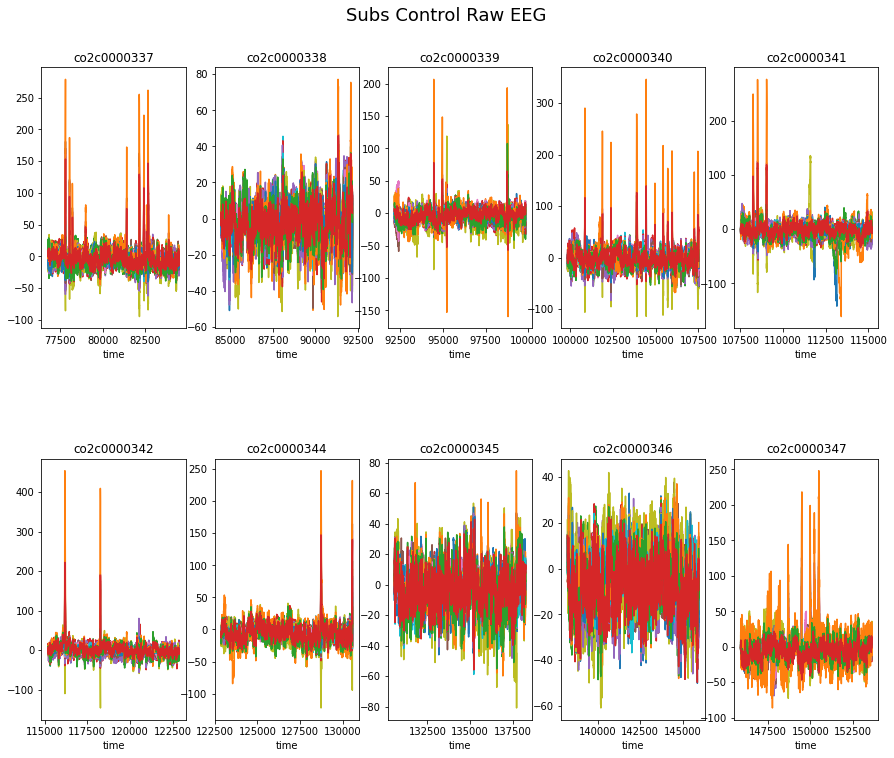

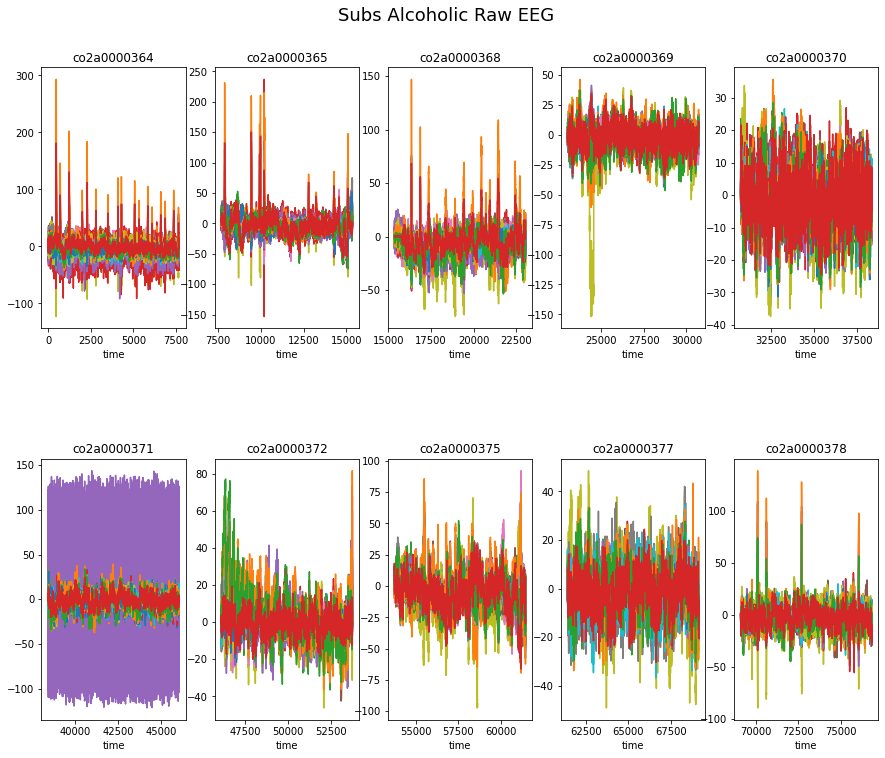

In [205]:
nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15, 12))                 
fig.suptitle("Subs Control Raw EEG", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

sublist=control['patient_no'].unique()
sublist_ind=pd.Series(control['patient_no']).drop_duplicates().index # where each trail starts and ends(sampling rate)  sampled at 256 Hz (3.9-msec epoch) for 1 second.

for sub, ax in zip(range(len(sublist)),axs.ravel()):
# for sub, ax in zip(sublist, axs.ravel()):

    start=int(sublist_ind[sub])
    stop =int(sublist_ind[sub]+7680)
#     print(start)
#     print(stop)
#     print()
    crt_sub=control.drop(['sample','match','patient_no'], axis=1)
    
#     crt_sub1=crt_sub.to_numpy()
#     print(crt_sub1)

#     crt_sub2=crt_sub1[start:stop:1,:]
    crt_sub2=crt_sub.loc[start:stop]
#     crt_sub2
#     print(crt_sub.shape)
#     crt_sub.plot(ax=ax)
    ax.plot(crt_sub2)
    ax.set_title(control_patients[sub])
    ax.set_xlabel("time")
    
plt.savefig('Subs Control Raw EEG.png')
plt.show()
    
    
    
    
    
nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15, 12))                 
fig.suptitle("Subs Alcoholic Raw EEG", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

sublist=alcoholic['patient_no'].unique()
sublist_ind=pd.Series(alcoholic['patient_no']).drop_duplicates().index # where each trail starts and ends(sampling rate)  sampled at 256 Hz (3.9-msec epoch) for 1 second.

for sub, ax in zip(range(len(sublist)),axs.ravel()):
# for sub, ax in zip(sublist, axs.ravel()):

    start=int(sublist_ind[sub])
    stop =int(sublist_ind[sub]+7680)
#     print(start)
#     print(stop)
#     print()
    alc_sub=alcoholic.drop(['sample','match','patient_no'], axis=1)
    
#     crt_sub1=crt_sub.to_numpy()
#     print(crt_sub1)

#     crt_sub2=crt_sub1[start:stop:1,:]
    alc_sub2=alc_sub.loc[start:stop]
#     crt_sub2
#     print(crt_sub.shape)
#     crt_sub.plot(ax=ax)
    ax.plot(alc_sub2)
    ax.set_title(alcoholic_patients[sub])
    ax.set_xlabel("time")
    
    
plt.savefig('Subs Alcoholic Raw EEG.png')
plt.show()
    

[[ 0.0000e+00 -2.0000e-02 -6.0320e+00 ...  4.4050e+00  2.6194e+01
   2.7970e+00]
 [ 1.0000e+00  4.6800e-01 -6.5210e+00 ...  1.9630e+00  2.4729e+01
   2.3090e+00]
 [ 2.0000e+00  1.4450e+00 -5.5440e+00 ... -2.4310e+00  1.8870e+01
   1.8210e+00]
 ...
 [ 2.5300e+02  8.0060e+00  1.6622e+01 ...  1.1180e+01  1.1149e+01
   9.5720e+00]
 [ 2.5400e+02  6.0530e+00  1.3692e+01 ...  2.6316e+01  1.0661e+01
   1.2502e+01]
 [ 2.5500e+02  4.1000e+00  8.3210e+00 ...  3.4617e+01  8.2190e+00
   1.3479e+01]]
(10, 65)


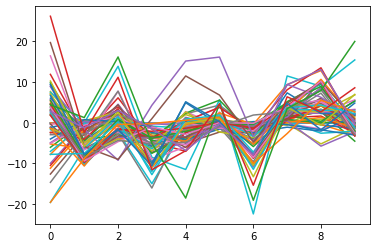

In [185]:
crt_sub1=crt_sub.to_numpy()
#     alc_sub=alc[start:stop:1,:,:].mean(axis=0)
print(crt_sub1)

crt_sub2=crt_sub1[0:76800:7680,:]
print(crt_sub2.shape)
plt.plot(crt_sub2)
plt.show()

In [197]:
crt_sub.loc[76800:84480]

,sample,AF1,AF2,AF7,AF8,AFZ,C1,C2,C3,C4,...,PO8,POZ,PZ,T7,T8,TP7,TP8,X,Y,nd
76800,0,-0.020,-6.032,11.902,-9.959,-2.472,-0.397,1.994,7.690,-1.689,...,19.725,3.835,2.930,10.254,-7.762,9.359,-19.552,4.405,26.194,2.797
76801,1,0.468,-6.521,10.437,-11.912,-2.472,-4.791,6.877,6.714,4.171,...,-10.549,3.347,1.953,7.324,-10.691,7.406,-16.134,1.963,24.729,2.309
76802,2,1.445,-5.544,7.507,-12.400,-1.007,-1.862,-13.631,4.761,4.659,...,1.658,2.370,1.465,3.418,-12.644,4.476,-9.786,-2.431,18.870,1.821
76803,3,2.909,-2.614,5.554,-8.982,0.946,-4.303,-1.424,3.784,-0.224,...,3.123,1.882,1.953,3.418,-11.180,3.011,-3.927,-3.896,13.499,1.821
76804,4,3.886,0.804,5.554,-3.123,3.387,0.092,0.041,3.296,-5.595,...,1.170,2.858,2.930,7.812,-5.809,4.476,-1.485,-2.431,12.034,3.286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84476,252,-6.724,-8.250,-2.584,-8.820,-6.755,-2.258,-0.895,-0.590,-5.839,...,-2.553,-6.337,-0.336,-7.914,-12.065,-6.927,-15.055,-6.307,-4.791,-5.636
84477,253,-8.677,-9.226,-6.002,-6.866,-8.708,-0.305,5.941,-2.543,-2.909,...,-2.065,-1.943,2.106,-4.008,-7.670,-3.510,-14.079,-5.819,-4.303,-8.565
84478,254,-11.607,-9.715,-11.861,-7.843,-10.173,-0.793,4.476,-5.961,-1.444,...,-8.413,0.498,2.594,-3.520,-6.694,-3.998,-11.149,-6.307,-6.744,-11.495
84479,255,-14.537,-10.691,-18.209,-10.284,-12.126,-2.747,-3.337,-8.403,-2.421,...,-8.901,0.987,1.617,-7.426,-9.623,-7.904,-8.708,-8.748,-11.627,-14.425
